# Parameter Estimation
---

Last session we built a neural network that could predict whether a chemical compound was toxic to bacteria. Feed it a growth curve, and out came a prediction: toxic or not. The model worked well. But if you asked it why a compound was toxic, all you got was a shrug and some weights. The network learned patterns, but it didn't learn biology.

Today we're taking a different approach. Instead of letting an algorithm find patterns, we write down the chemistry (substrate + cell → two cells), work out the differential equations, and then ask: what rate constants make this model match my data?

Why bother when machine learning works so well? Because when you estimate $k = 0.5~\mathrm{h}^{-1}~\mathrm{OD}^{-1}$, that number means something. You can compare it across conditions, relate it to molecular mechanisms, predict behavior under new conditions. A neural network trained on one concentration range might fail catastrophically on another, but a mechanistic model grounded in chemistry keeps working. And when you want to test a hypothesis (does the antibiotic affect substrate affinity or maximum growth rate?), you can answer it by fitting parameters. You can't answer it by examining neural network weights.

The price is that parameter estimation is an inverse problem. You're working backward from noisy observations to underlying causes. Inverse problems are poorly behaved. Small changes in data can produce large changes in estimated parameters. Multiple parameter sets can produce nearly identical curves. The optimization landscape is riddled with local minima. This session teaches you to navigate that landscape.

## The logistic growth model

Previously we derived logistic growth from a simple chemical reaction network:

$$S + X \xrightarrow{k} 2X$$

A substrate molecule collides with a cell, producing two cells. Mass-action kinetics gives $dX/dt = kXS$. Conservation of mass says $S + X = S_0 + X_0$. Substitute and you get:

$$\frac{dX}{dt} = kX(S_0 + X_0 - X)$$

This is the logistic equation. Three parameters: $k$ is the reaction rate constant ($\mathrm{h}^{-1}~\mathrm{OD}^{-1}$), $S_0$ is the initial substrate ($\mathrm{OD}$), $X_0$ is the initial cell density ($\mathrm{OD}$).

The forward problem is straightforward: given parameters, integrate the ODE to predict the curve. Today we solve the inverse problem: given measurements $(t_1, y_1), \ldots, (t_n, y_n)$, find the parameters $(k, S_0, X_0)$ that produced them.

## The objective function

To estimate parameters, you need a measure of fit quality. The standard choice is sum of squared errors:

$$J(\theta) = \sum_{i=1}^{n} \left[ y_i - X(t_i; \theta) \right]^2$$

where $\theta = (k, S_0, X_0)$. For each time point, you compute the difference between measurement and prediction, square it so positive and negative errors don't cancel, then sum them up. Lower is better. Zero means perfect agreement.

Your goal is to find $\theta^* = \arg\min_{\theta} J(\theta)$.

Why squared errors? Because they're differentiable, they penalize large errors more heavily, and there are fast algorithms for minimizing them. But this is a choice, not a law of nature. You could use absolute errors, or even asymmetric penalties if outliers bother you more in one direction. For this session we'll stick with squared errors because that's what most software expects.

## Implementation with units

Before we can optimize anything, we need to simulate growth. Here's the setup:

In [1]:
# % pip install numpy matplotlib pint solve_ivp_pint scipy

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pint import UnitRegistry
from solve_ivp_pint import solve_ivp
from scipy.optimize import minimize, differential_evolution
import time

ureg = UnitRegistry()
Q = ureg.Quantity
ureg.define('OD = [] = optical_density')

rng = np.random.default_rng(42)

def logistic_rhs(t, y, k, S0, X0):
    """Right-hand side of logistic ODE"""
    X = y[0]
    S = S0 + X0 - X
    dXdt = k * X * S
    return [dXdt]

def simulate_logistic(t_points, k, S0, X0):
    """Integrate the logistic growth ODE"""
    y0 = [X0]
    t_span = (t_points[0], t_points[-1])
    
    sol = solve_ivp(logistic_rhs, t_span, y0, args=(k, S0, X0),
                    t_eval=t_points, method='LSODA')
    
    y_list = sol.y[0]
    y_array = Q(np.array([y.m for y in y_list]), y_list[0].units)
    return y_array

print("Setup complete!")

Setup complete!


Now generate some synthetic data to test our methods:

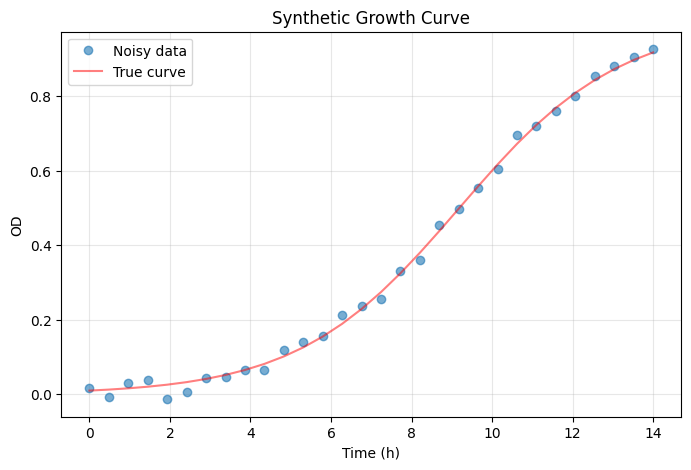

In [3]:
k_true = Q(0.5, 'hour**-1 / OD')
S0_true = Q(0.99, 'OD')
X0_true = Q(0.01, 'OD')
K_true = S0_true + X0_true

t_data = Q(np.linspace(0, 14, 30), 'hour')
y_true = simulate_logistic(t_data, k_true, S0_true, X0_true)
y_data = y_true + Q(rng.normal(0, 0.02, len(t_data)), 'OD')

plt.figure(figsize=(8, 5))
plt.plot(t_data.m, y_data.m, 'o', alpha=0.6, label='Noisy data')
plt.plot(t_data.m, y_true.m, 'r-', alpha=0.5, label='True curve')
plt.xlabel('Time (h)')
plt.ylabel('OD')
plt.title('Synthetic Growth Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

This gives us a "perfect" growth curve with known parameters, plus measurement noise. Now we can test whether our optimization methods can recover the true parameters from noisy data.

## The optimization landscape

Before trying to find the minimum, let's visualize what we're up against. We'll compute $J(\theta)$ for many different parameter values and plot it. Since we have three parameters we can't visualize the full space, but we can fix $X_0$ at its true value and plot $J$ as a function of $k$ and $K = S_0 + X_0$:

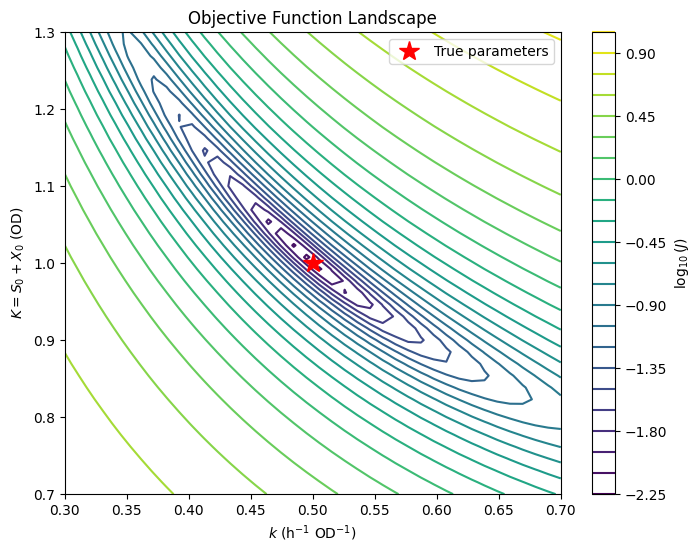

In [4]:
k_values = np.linspace(0.3, 0.7, 40)
K_values = np.linspace(0.7, 1.3, 40)

J = np.zeros((len(K_values), len(k_values)))
for i, K_val in enumerate(K_values):
    for j, k_val in enumerate(k_values):
        k_test = Q(k_val, 'hour**-1 / OD')
        K_test = Q(K_val, 'OD')
        S0_test = K_test - X0_true
        
        y_pred = simulate_logistic(t_data, k_test, S0_test, X0_true)
        J[i, j] = np.sum(((y_data - y_pred).m_as('OD'))**2)

plt.figure(figsize=(8, 6))
plt.contour(k_values, K_values, np.log10(J), levels=20, cmap='viridis')
plt.plot(k_true.m, K_true.m, 'r*', markersize=15, label='True parameters')
plt.xlabel(r'$k$ ($\mathrm{h}^{-1}~\mathrm{OD}^{-1}$)')
plt.ylabel(r'$K = S_0 + X_0$ ($\mathrm{OD}$)')
plt.title('Objective Function Landscape')
plt.colorbar(label=r'$\log_{10}(J)$')
plt.legend()
plt.show()

The landscape has a clear minimum near the true parameters. But notice the shape: the contours are elongated diagonally. This happens because $k$ and $K$ are correlated through their product $\mu = kK$, which determines the exponential growth rate. If you increase $k$ while decreasing $K$ proportionally, you can keep $\mu$ nearly constant, so the fit quality doesn't change much. The valley runs along this diagonal direction.

This shape matters for optimization. Gradient methods struggle with elongated valleys. They tend to oscillate across the narrow direction while making slow progress along the long direction.

## Identifiability: when your data doesn't tell you enough

Sometimes your data simply doesn't contain enough information to determine all parameters. This is the identifiability problem. Let me show you an example.

Compare two scenarios. First, you measure a full growth curve from exponential phase through plateau, 0 to 14 hours. The curve shows you the initial density ($X_0 \approx 0.01$ OD), the exponential growth rate ($\mu = k(S_0 + X_0) \approx 0.5~\mathrm{h}^{-1}$), and the plateau height ($K = S_0 + X_0 \approx 1.0$ OD). From these three observables you can recover all three CRN parameters.

Now suppose you only measure during exponential growth, 0 to 5 hours, before the plateau. You still see $X_0$ and $\mu$, but you never see where the plateau is. During exponential growth the model simplifies to $X(t) \approx X_0 e^{\mu t}$. This doesn't depend on $K$ at all. You could have $K = 1.0$, $K = 2.0$, or $K = 10.0$, and all three would produce identical exponential phases.

Let's visualize this by comparing the objective landscapes:

Full curve: max OD = 0.937
Exp-only: max OD = 0.111 (11.1% of K)


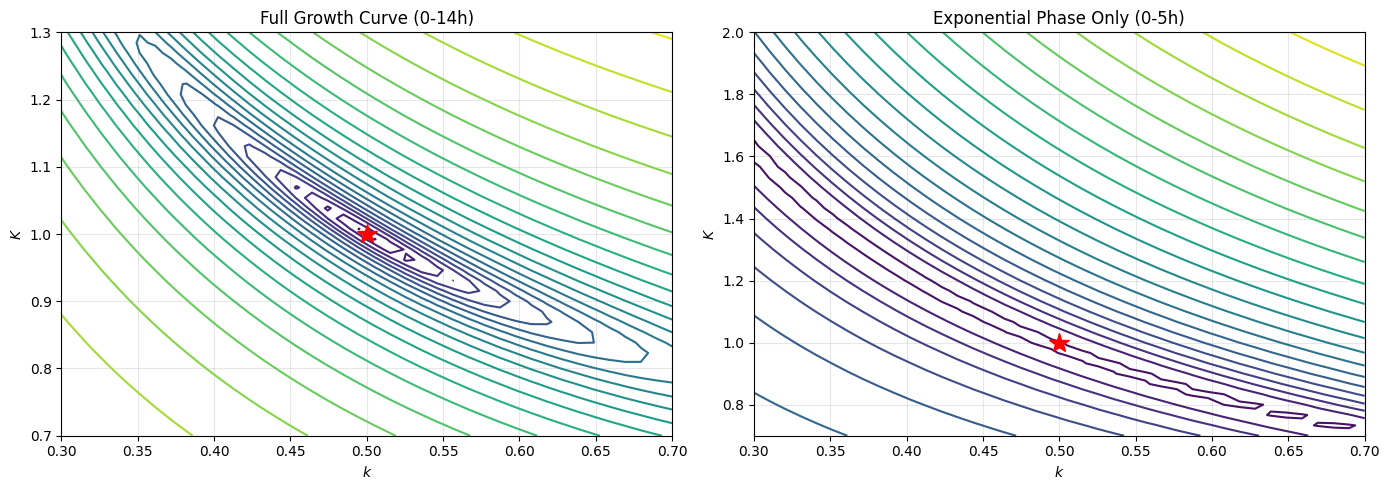

In [5]:
# Full curve: 0-14h (includes plateau)
t_full = Q(np.linspace(0, 14, 30), 'hour')
y_full = simulate_logistic(t_full, k_true, S0_true, X0_true)
y_full = y_full + Q(rng.normal(0, 0.02, len(t_full)), 'OD')

# Exponential only: 0-5h (no plateau)
t_exp_only = Q(np.linspace(0, 5, 15), 'hour')
y_exp_only = simulate_logistic(t_exp_only, k_true, S0_true, X0_true)
y_exp_only = y_exp_only + Q(rng.normal(0, 0.01, len(t_exp_only)), 'OD')

print(f"Full curve: max OD = {y_full.max().m:.3f}")
print(f"Exp-only: max OD = {y_exp_only.max().m:.3f} ({y_exp_only.max().m/K_true.m*100:.1f}% of K)")

# Compute landscapes for both
K_values_wide = np.linspace(0.7, 2.0, 40)

J_full = np.zeros((len(K_values), len(k_values)))
J_exp = np.zeros((len(K_values_wide), len(k_values)))

for i, K_val in enumerate(K_values):
    for j, k_val in enumerate(k_values):
        k_test = Q(k_val, 'hour**-1 / OD')
        K_test = Q(K_val, 'OD')
        S0_test = K_test - X0_true
        y_pred = simulate_logistic(t_full, k_test, S0_test, X0_true)
        J_full[i, j] = np.sum(((y_full - y_pred).m_as('OD'))**2)

for i, K_val in enumerate(K_values_wide):
    for j, k_val in enumerate(k_values):
        k_test = Q(k_val, 'hour**-1 / OD')
        K_test = Q(K_val, 'OD')
        S0_test = K_test - X0_true
        y_pred = simulate_logistic(t_exp_only, k_test, S0_test, X0_true)
        J_exp[i, j] = np.sum(((y_exp_only - y_pred).m_as('OD'))**2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.contour(k_values, K_values, np.log10(J_full), levels=20, cmap='viridis')
ax1.plot(k_true.m, K_true.m, 'r*', markersize=15)
ax1.set_xlabel(r'$k$')
ax1.set_ylabel(r'$K$')
ax1.set_title('Full Growth Curve (0-14h)')
ax1.grid(True, alpha=0.3)

ax2.contour(k_values, K_values_wide, np.log10(J_exp), levels=20, cmap='viridis')
ax2.plot(k_true.m, K_true.m, 'r*', markersize=15)
ax2.set_xlabel(r'$k$')
ax2.set_ylabel(r'$K$')
ax2.set_title('Exponential Phase Only (0-5h)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

The difference is striking. For the full curve (left panel), you get tight contours around the true parameters. Well-defined minimum. For the exponential-only data (right panel), you get extremely elongated contours along a diagonal direction. This is much more severe than the full curve case. During exponential growth, only the product $kK = \mu$ matters, so any $(k, K)$ pair with the same product fits equally well. You can vary $K$ from 0.7 to 2.0 as long as you adjust $k$ proportionally, and the fit quality barely changes.

Look at the numbers. With exponential-only data, the max OD is only 11% of the carrying capacity. The objective function is nearly flat along the diagonal. Along this line where $kK$ stays constant, you can have vastly different individual values of $k$ and $K$ with barely any change in fit quality. This is practical non-identifiability. The model structure allows both parameters to be determined in principle, but your particular dataset doesn't include the information because you didn't measure the plateau.

What do you do about this? Measure longer to capture the plateau. Or fix $K$ at a reasonable value. Or accept that you can only estimate $\mu$ and $X_0$. The key lesson is: don't try to extract information that isn't in your data.

## Reparameterization: choosing better variables

Before we start optimizing, let's make a smart choice about variables. Instead of working with $(k, S_0, X_0)$ directly, we'll use:

$$\mu = k(S_0 + X_0) \quad \text{(exponential growth rate)}$$
$$K = S_0 + X_0 \quad \text{(carrying capacity)}$$
$$X_0 = X_0 \quad \text{(initial density)}$$

Why? Because these correspond to observable features of the growth curve. You can estimate $\mu$ from the slope of $\log X$ vs. $t$ during exponential phase. You can read $K$ off the plateau height. You can measure $X_0$ directly at $t=0$. These parameters are more independent (each comes from a different part of the curve), which makes the optimization landscape nicer.

You can always convert back to CRN parameters: $k = \mu/K$ and $S_0 = K - X_0$.

From now on we work in $(\mu, K, X_0)$ space. Here's the objective function:

In [6]:
def objective(params, t_data, y_data):
    """Objective function in (μ, K, X0) parameterization"""
    mu, K, X0 = params
    
    if K <= 0 or X0 <= 0 or mu <= 0:
        return 1e10
    
    k = mu / K
    S0 = K - X0
    
    try:
        y_pred = simulate_logistic(t_data, Q(k, 'hour**-1 / OD'),
                                   Q(S0, 'OD'), Q(X0, 'OD'))
        residuals = (y_data - y_pred).m_as('OD')
        return np.sum(residuals**2)
    except:
        return 1e10

print("Objective function defined in (μ, K, X0) parameterization")

Objective function defined in (μ, K, X0) parameterization


## Gradient descent: fast but fragile

The simplest optimization method is gradient descent. Start with an initial guess, compute which direction is downhill, take a step in that direction, repeat until you reach the bottom. We'll use scipy's L-BFGS-B implementation, which is a sophisticated gradient method that handles constraints.

L-BFGS-B stands for Limited-memory Broyden-Fletcher-Goldfarb-Shanno with Bounds. It's a quasi-Newton method, meaning it uses gradient information (first derivatives) to approximate the Hessian matrix (second derivatives) without actually computing it. Here's the mathematical foundation.

Newton's method for minimization uses the update rule:

$$\theta_{k+1} = \theta_k - H_k^{-1} \nabla J(\theta_k)$$

where $\nabla J$ is the gradient (first derivatives) and $H$ is the Hessian matrix of second derivatives:

$$H_{ij} = \frac{\partial^2 J}{\partial \theta_i \partial \theta_j}$$

The Hessian tells you the local curvature. If $J$ is a quadratic bowl, Newton's method finds the bottom in one step. The problem is computing $H$ and inverting it costs $O(n^3)$ operations for $n$ parameters, and you need to do this every iteration.

BFGS instead maintains an approximation $B_k \approx H_k$ that gets updated at each iteration using only gradient information. When you move from $\theta_k$ to $\theta_{k+1}$, you observe how the gradient changed: $y_k = \nabla J(\theta_{k+1}) - \nabla J(\theta_k)$ and how far you moved: $s_k = \theta_{k+1} - \theta_k$. The BFGS update formula uses these to improve the Hessian approximation:

$$B_{k+1} = B_k + \frac{y_k y_k^T}{y_k^T s_k} - \frac{B_k s_k s_k^T B_k}{s_k^T B_k s_k}$$

The genius is that this formula guarantees $B_{k+1}$ stays positive definite (so you always move downhill) and incorporates the observed curvature information. The "limited memory" part means instead of storing the full matrix $B_k$, you only keep the last $m$ pairs $(s_k, y_k)$ (typically $m = 10$) and reconstruct the approximation on the fly. This reduces memory from $O(n^2)$ to $O(mn)$. The "B" adds box constraints: you can specify $\theta_i \in [l_i, u_i]$, and the algorithm projects the Newton step back into the feasible region at each iteration.

With a good initial guess, this works beautifully:

Fitted parameters:
  mu = 0.4937 h⁻¹ (true: 0.5000)
  K = 1.0122 OD (true: 1.0000)
  X0 = 0.0105 OD (true: 0.0100)
  Objective: 0.006840
  Time: 0.41s


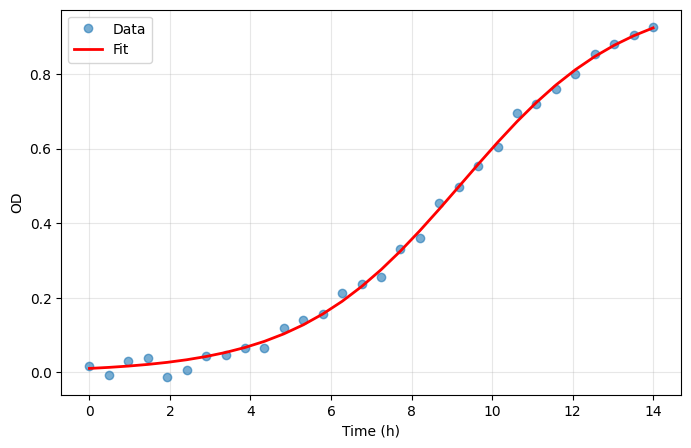

In [7]:
initial_guess = [0.45, 0.95, 0.015]

t0 = time.time()
result_good = minimize(objective, initial_guess, args=(t_data, y_data),
                       method='L-BFGS-B', options={'maxiter': 500})
t_good = time.time() - t0

mu_fit, K_fit, X0_fit = result_good.x

print(f"Fitted parameters:")
print(f"  mu = {mu_fit:.4f} h⁻¹ (true: {(k_true * K_true).m:.4f})")
print(f"  K = {K_fit:.4f} OD (true: {K_true.m:.4f})")
print(f"  X0 = {X0_fit:.4f} OD (true: {X0_true.m:.4f})")
print(f"  Objective: {result_good.fun:.6f}")
print(f"  Time: {t_good:.2f}s")

y_fit = simulate_logistic(t_data, Q(mu_fit/K_fit, 'hour**-1 / OD'),
                         Q(K_fit - X0_fit, 'OD'), Q(X0_fit, 'OD'))

plt.figure(figsize=(8, 5))
plt.plot(t_data.m, y_data.m, 'o', alpha=0.6, label='Data')
plt.plot(t_data.m, y_fit.m, 'r-', linewidth=2, label='Fit')
plt.xlabel('Time (h)')
plt.ylabel('OD')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Nearly perfect recovery of the true parameters in less than a second. But here's the problem: what if you don't have a good initial guess?

Let's test gradient descent from 10 random starting points and see what happens:

In [8]:
n_trials = 10
rng_init = np.random.default_rng(123)
successes = 0

print("Testing gradient descent from random starting points:")
print("=" * 70)

for i in range(n_trials):
    mu_init = rng_init.uniform(0.05, 1.5)
    K_init = rng_init.uniform(0.2, 2.0)
    X0_init = rng_init.uniform(0.005, 0.1)
    
    result = minimize(objective, [mu_init, K_init, X0_init],
                     args=(t_data, y_data), method='L-BFGS-B',
                     options={'maxiter': 500})
    
    mu_r, K_r, X0_r = result.x
    
    mu_err = abs(mu_r - (k_true * K_true).m) / (k_true * K_true).m * 100
    K_err = abs(K_r - K_true.m) / K_true.m * 100
    X0_err = abs(X0_r - X0_true.m) / X0_true.m * 100
    
    success = mu_err < 10 and K_err < 10 and X0_err < 10
    if success:
        successes += 1
    
    status = "✓" if success else "✗"
    print(f"{status} Trial {i+1:2d}: mu={mu_r:.3f}, K={K_r:.3f}, X0={X0_r:.3f}, J={result.fun:.3f}")

print("=" * 70)
print(f"Success rate: {successes}/{n_trials} = {successes/n_trials*100:.0f}%")

Testing gradient descent from random starting points:
✗ Trial  1: mu=1.039, K=0.297, X0=0.026, J=2.343
✓ Trial  2: mu=0.494, K=1.012, X0=0.010, J=0.007
✗ Trial  3: mu=1.389, K=0.698, X0=0.083, J=1.791
✗ Trial  4: mu=1.340, K=1.123, X0=0.028, J=9.791
✗ Trial  5: mu=1.245, K=0.585, X0=0.075, J=1.704
✗ Trial  6: mu=0.963, K=1.869, X0=0.027, J=27.230
✗ Trial  7: mu=1.209, K=1.133, X0=0.027, J=8.826
✓ Trial  8: mu=0.494, K=1.012, X0=0.010, J=0.007
✓ Trial  9: mu=0.494, K=1.012, X0=0.010, J=0.007
✗ Trial 10: mu=1.106, K=1.853, X0=0.064, J=29.099
Success rate: 3/10 = 30%


Gradient descent failed 70% of the time. When started far from the optimum, it got stuck.

This is the fundamental limitation of gradient methods. They're local searchers. They follow the gradient downhill to the nearest local minimum, but they have no mechanism to escape and explore the broader landscape. If you start in the wrong basin, you're stuck there.

So when should you use gradient descent? When you have a good initial guess, it's the fastest method. When you're refining an already decent fit. When speed matters more than robustness. But if you have no idea where the parameters are, or if multiple local minima are likely, or if you can't afford to fail, you need something else.

## Global optimization: differential evolution

When gradient descent fails, you need global optimization. These methods explore the entire parameter space, not just descend to the nearest minimum. We'll use differential evolution. 

The basic idea is evolutionary: maintain a population of candidate solutions, create new candidates by combining existing ones, keep the better ones, repeat until convergence. Here's how it works.

Start with a population of candidate parameter sets scattered randomly across your search space. Say you have 15 candidates, each representing a different $(\mu, K, X_0)$ combination. At each iteration, for every candidate in the population, you create a trial candidate by:

1. Pick three other candidates from the population at random, call them A, B, C
2. Create a mutant vector: $\text{mutant} = A + F \cdot (B - C)$, where $F$ is a scaling factor (typically 0.5 to 1.0)
3. Mix the mutant with the current candidate using crossover: for each parameter, randomly decide whether to take it from the mutant or keep the original (crossover probability typically 0.7)
4. Evaluate the trial candidate: compute $J(\text{trial})$
5. If the trial is better than the current candidate, replace it. Otherwise keep the current one.

The key insight is that the difference vector $(B - C)$ points in a direction that connects two existing candidates, and scaling it by $F$ controls how far you jump. By adding this to candidate A, you explore new regions of parameter space that are informed by where good solutions already exist. Over many iterations, the population converges toward the global minimum as worse candidates get replaced by better ones.

Unlike gradient descent, differential evolution doesn't need an initial guess. You just specify bounds:

In [9]:
bounds = [(0.01, 1.5),   # mu
          (0.1, 2.0),    # K
          (0.001, 0.1)]  # X0

t0 = time.time()
result_de = differential_evolution(objective, bounds, args=(t_data, y_data),
                                  strategy='best1bin', maxiter=300, seed=42)
t_de = time.time() - t0

mu_de, K_de, X0_de = result_de.x

print(f"Differential evolution:")
print(f"  mu = {mu_de:.4f} h⁻¹ (true: {(k_true * K_true).m:.4f})")
print(f"  K = {K_de:.4f} OD (true: {K_true.m:.4f})")
print(f"  X0 = {X0_de:.4f} OD (true: {X0_true.m:.4f})")
print(f"  Objective: {result_de.fun:.6f}")
print(f"  Time: {t_de:.2f}s")
print(f"  Function evaluations: {result_de.nfev}")
print(f"\nFound the answer without any initial guess, but took {t_de/t_good:.0f}× longer")

Differential evolution:
  mu = 0.4937 h⁻¹ (true: 0.5000)
  K = 1.0122 OD (true: 1.0000)
  X0 = 0.0105 OD (true: 0.0100)
  Objective: 0.006840
  Time: 8.85s
  Function evaluations: 1900

Found the answer without any initial guess, but took 22× longer


It found the answer without any initial guess. But notice it took about 9 seconds instead of about 0.4 seconds, and it needed about 1900 function evaluations. The trade-off is clear: gradient descent is fast if you have a good guess, fragile if you don't. Differential evolution is robust but slow.

## Combined strategy: get both

Can we get robustness without sacrificing too much speed? Yes. Use differential evolution to get into the right basin, then switch to gradient descent for fast convergence:

In [10]:
t0 = time.time()

# Quick global search (20 iterations)
result_de_quick = differential_evolution(objective, bounds, args=(t_data, y_data),
                                        maxiter=20, seed=42)

# Local refinement
result_final = minimize(objective, result_de_quick.x, args=(t_data, y_data),
                       method='L-BFGS-B', options={'maxiter': 500})

t_combined = time.time() - t0

mu_final, K_final, X0_final = result_final.x

print(f"Combined strategy (DE 20 iter + GD):")
print(f"  μ = {mu_final:.4f} h⁻¹")
print(f"  K = {K_final:.4f} OD")
print(f"  X₀ = {X0_final:.4f} OD")
print(f"  Objective: {result_final.fun:.6f}")
print(f"  Time: {t_combined:.2f}s")
print(f"\nComparison:")
print(f"  Gradient descent (good guess): {t_good:.2f}s")
print(f"  Differential evolution (full): {t_de:.2f}s")
print(f"  Combined strategy: {t_combined:.2f}s")
print(f"\nCombined is {t_de/t_combined:.1f}× faster than full DE")

Combined strategy (DE 20 iter + GD):
  μ = 0.4937 h⁻¹
  K = 1.0122 OD
  X₀ = 0.0105 OD
  Objective: 0.006840
  Time: 5.02s

Comparison:
  Gradient descent (good guess): 0.41s
  Differential evolution (full): 8.85s
  Combined strategy: 5.02s

Combined is 1.8× faster than full DE


The combined strategy is nearly twice as fast as full differential evolution while maintaining perfect robustness. It works because 20 iterations of DE is enough to get you into the right basin, then gradient descent efficiently zooms in on the precise minimum. You get global robustness plus local efficiency.

This is what you should use in practice unless you already have a good initial guess.

## Experimental data

Time to apply these methods to real data. We prepared some bacterial growth curves measured in a plate reader, 96-well format, OD600 every 5 minutes for 26 hours. The data file has 8 wells: A1 is a blank (no bacteria), B1 through H1 contain different bacterial cultures.

Load and parse:

In [11]:
with open('data/plate_reader.txt', 'r') as f:
    lines = f.readlines()

data_lines = [l.strip() for l in lines[1:] if l.strip() and not l.startswith('##')]
headers = data_lines[0].split('\t')

time_hours = []
well_data = {h: [] for h in headers[1:]}

for line in data_lines[1:]:
    parts = line.split('\t')
    time_str = parts[0]
    time_parts = time_str.split(':')
    total_hours = int(time_parts[0]) + int(time_parts[1])/60 + int(time_parts[2])/3600
    time_hours.append(total_hours)
    
    for i, header in enumerate(headers[1:], start=1):
        well_data[header].append(float(parts[i]))

time_hours = np.array(time_hours)

print(f"Loaded {len(time_hours)} time points from {len(headers)-1} wells")
print(f"Wells: {', '.join(headers[1:])}")

Loaded 313 time points from 8 wells
Wells: A1, B1, C1, D1, E1, F1, G1, H1


You have 313 time points over 26 hours, measurements every 5 minutes. Let's visualize:

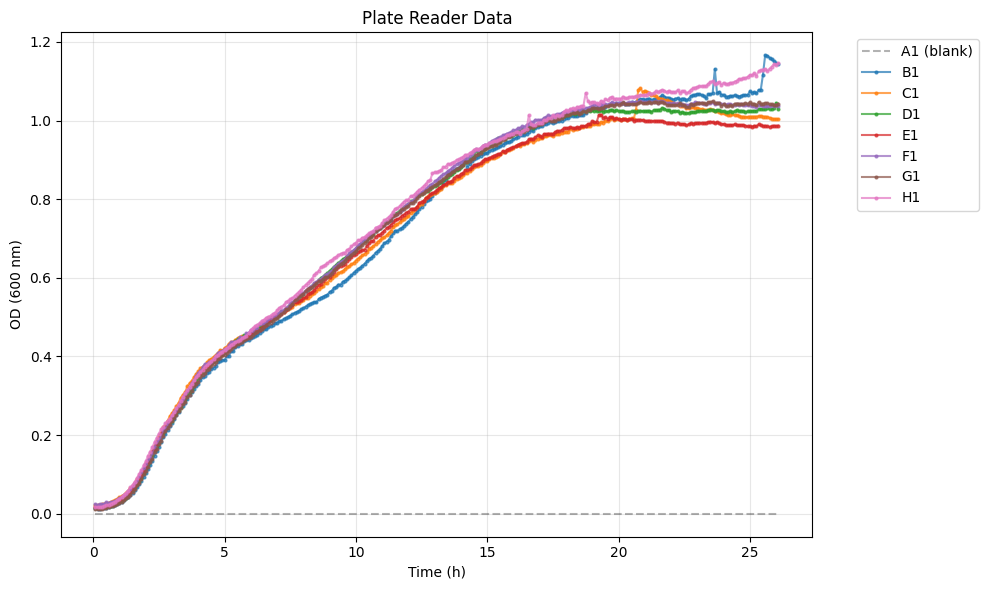

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))
for well in headers[1:]:
    od = np.array(well_data[well])
    if well == 'A1':
        ax.plot(time_hours, od, 'k--', alpha=0.3, label='A1 (blank)')
    else:
        ax.plot(time_hours, od, marker='o', markersize=2, label=well, alpha=0.7)

ax.set_xlabel('Time (h)')
ax.set_ylabel('OD (600 nm)')
ax.set_title('Plate Reader Data')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

The blank stays near zero as expected. All other wells show growth. Some reach different final ODs. Some show what looks like complex behavior, possibly two growth phases.

Let's fit the cleanest-looking well, D1, using our robust combined strategy:

In [13]:
t_exp = Q(time_hours, 'hour')
od_exp = Q(np.array(well_data['D1']), 'OD')

def objective_exp(params):
    mu, K, X0 = params
    if K <= 0 or X0 <= 0 or mu <= 0:
        return 1e10
    k = mu / K
    S0 = K - X0
    try:
        y_pred = simulate_logistic(t_exp, Q(k, 'hour**-1 / OD'),
                                   Q(S0, 'OD'), Q(X0, 'OD'))
        return np.sum(((od_exp - y_pred).m_as('OD'))**2)
    except:
        return 1e10

bounds_exp = [(0.01, 2.0), (0.1, 2.0), (0.001, 0.1)]
result_de_exp = differential_evolution(objective_exp, bounds_exp, maxiter=20, seed=42)
result_exp = minimize(objective_exp, result_de_exp.x, method='L-BFGS-B')

mu_exp, K_exp, X0_exp = result_exp.x

print(f"Well D1 fit:")
print(f"  mu = {mu_exp:.3f} h⁻¹")
print(f"  K = {K_exp:.3f} OD")
print(f"  X0 = {X0_exp:.4f} OD")
print(f"  Objective: {result_exp.fun:.4f}")

Well D1 fit:
  mu = 0.286 h⁻¹
  K = 1.040 OD
  X0 = 0.1120 OD
  Objective: 0.4611


Plot the fit and check the residuals:

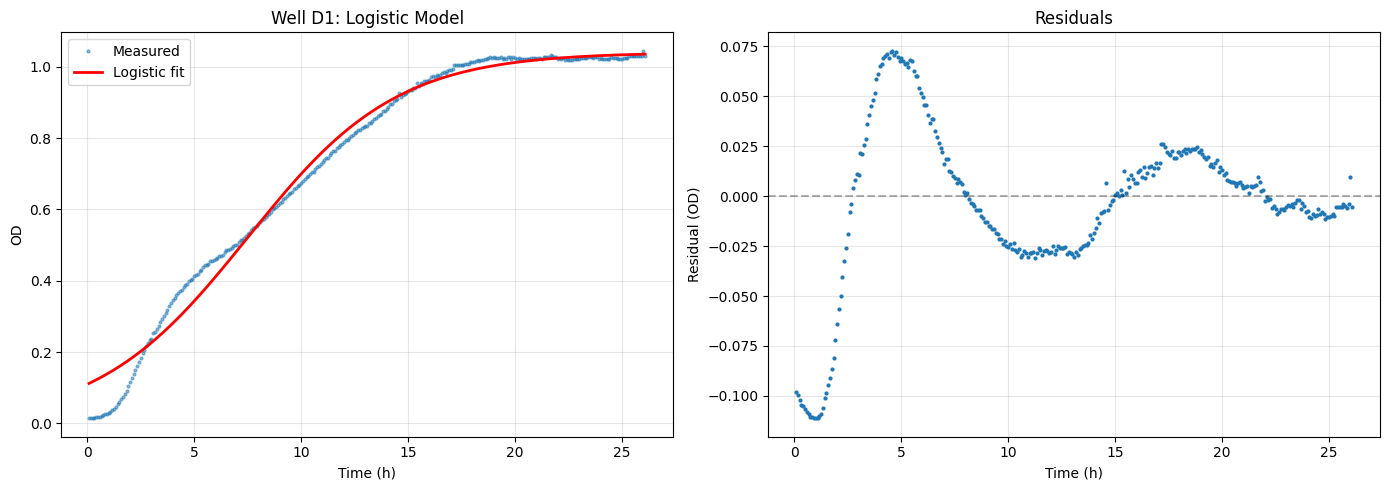

In [14]:
y_fit_exp = simulate_logistic(t_exp, Q(mu_exp/K_exp, 'hour**-1 / OD'),
                             Q(K_exp - X0_exp, 'OD'), Q(X0_exp, 'OD'))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(t_exp.m, od_exp.m, 'o', markersize=2, alpha=0.5, label='Measured')
ax1.plot(t_exp.m, y_fit_exp.m, 'r-', linewidth=2, label='Logistic fit')
ax1.set_xlabel('Time (h)')
ax1.set_ylabel('OD')
ax1.set_title('Well D1: Logistic Model')
ax1.legend()
ax1.grid(True, alpha=0.3)

residuals = od_exp.m - y_fit_exp.m
ax2.plot(t_exp.m, residuals, 'o', markersize=2)
ax2.axhline(0, color='k', linestyle='--', alpha=0.3)
ax2.set_xlabel('Time (h)')
ax2.set_ylabel('Residual (OD)')
ax2.set_title('Residuals')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

The residuals are small and randomly scattered around zero. Good sign. The simple logistic model fits this well.

## Model extensions: two parallel resources

Some wells show behavior that doesn't quite fit simple logistic growth. Well B1, for instance, has a more complex shape. Could there be two substrates supporting growth?

Instead of one substrate reaction ($S + X \xrightarrow{k} 2X$), consider two independent substrates:

$$S_1 + X \xrightarrow{k_1} 2X$$
$$S_2 + X \xrightarrow{k_2} 2X$$

The ODEs become:

$$\frac{dX}{dt} = k_1 X S_1 + k_2 X S_2$$
$$\frac{dS_1}{dt} = -k_1 X S_1$$
$$\frac{dS_2}{dt} = -k_2 X S_2$$

Initial conditions: $X(0) = X_0$, $S_1(0) = S_{1,0}$, $S_2(0) = S_{2,0}$. The total carrying capacity is $K = S_{1,0} + S_{2,0} + X_0$.

This model has five parameters instead of three. We can parameterize it as $(\mu_1, \mu_2, K_1, K_2, X_0)$ where $\mu_i = k_i K_i$ and $K_i = S_{i,0} + X_0$.

Implementation:

In [15]:
def two_resource_model(t, y, k1, k2, S1_0, S2_0, X_0):
    """Two parallel substrates supporting growth"""
    X, S1, S2 = y
    dXdt = k1 * X * S1 + k2 * X * S2
    dS1dt = -k1 * X * S1
    dS2dt = -k2 * X * S2
    return [dXdt, dS1dt, dS2dt]

def simulate_two_resource(t_points, k1, k2, S1_0, S2_0, X_0):
    """Simulate 2-resource growth with pint units"""
    y0 = [X_0, S1_0, S2_0]
    t_span = (t_points[0], t_points[-1])
    
    sol = solve_ivp(
        two_resource_model,
        t_span,
        y0,
        args=(k1, k2, S1_0, S2_0, X_0),
        t_eval=t_points,
        method='LSODA'
    )
    
    # Extract X (first component)
    X_list = sol.y[0]
    X_array = Q(np.array([X.m for X in X_list]), X_list[0].units)
    return X_array

Let's compare single versus two-resource models on Well B1:

In [16]:
t_exp_b1 = Q(time_hours, 'hour')
od_exp_b1 = Q(np.array(well_data['B1']), 'OD')

# Fit single-resource
def objective_single(params):
    mu, K, X0 = params
    if K <= 0 or X0 <= 0 or mu <= 0:
        return 1e10
    k = mu / K
    S0 = K - X0
    try:
        y_pred = simulate_logistic(t_exp_b1, Q(k, 'hour**-1 / OD'),
                                   Q(S0, 'OD'), Q(X0, 'OD'))
        return np.sum(((od_exp_b1 - y_pred).m_as('OD'))**2)
    except:
        return 1e10

result_single = minimize(objective_single, [0.5, 1.0, 0.015],
                        method='L-BFGS-B', options={'maxiter': 1000})
mu_s, K_s, X0_s = result_single.x
print(f'{mu_s=:.3f}, {K_s=:.3f}, {X0_s=:.3f}')

# Fit two-resource
def objective_two(params):
    mu1, mu2, K1, K2, X0 = params
    if any(p <= 0 for p in params):
        return 1e10
    k1, k2 = mu1/K1, mu2/K2
    S1_0, S2_0 = K1 - X0, K2 - X0
    try:
        y_pred = simulate_two_resource(t_exp_b1, Q(k1, 'hour**-1 / OD'), Q(k2, 'hour**-1 / OD'),
                                       Q(S1_0, 'OD'), Q(S2_0, 'OD'), Q(X0, 'OD'))
        return np.sum(((od_exp_b1 - y_pred).m_as('OD'))**2)
    except:
        return 1e10

result_two = minimize(objective_two, [0.4, 0.3, 0.5, 0.5, 0.015],
                     method='L-BFGS-B', options={'maxiter': 2000})
mu1_t, mu2_t, K1_t, K2_t, X0_t = result_two.x
print(f'{mu1_t=:.3f}, {mu2_t=:.3f}, {K1_t=:.3f}, {K2_t=:.3f}, {X0_t=:.3f}')

mu_s=0.249, K_s=1.099, X0_s=0.120
mu1_t=0.791, mu2_t=0.168, K1_t=0.241, K2_t=0.922, X0_t=0.030


The two-resource model improves the fit. This suggests the bacteria first consume a rapidly metabolizable substrate, giving fast early growth, then switch to a slower substrate, giving continued but slower growth. This is consistent with diauxic growth, a well-known phenomenon when bacteria have multiple carbon sources.

Plot both fits with residuals:

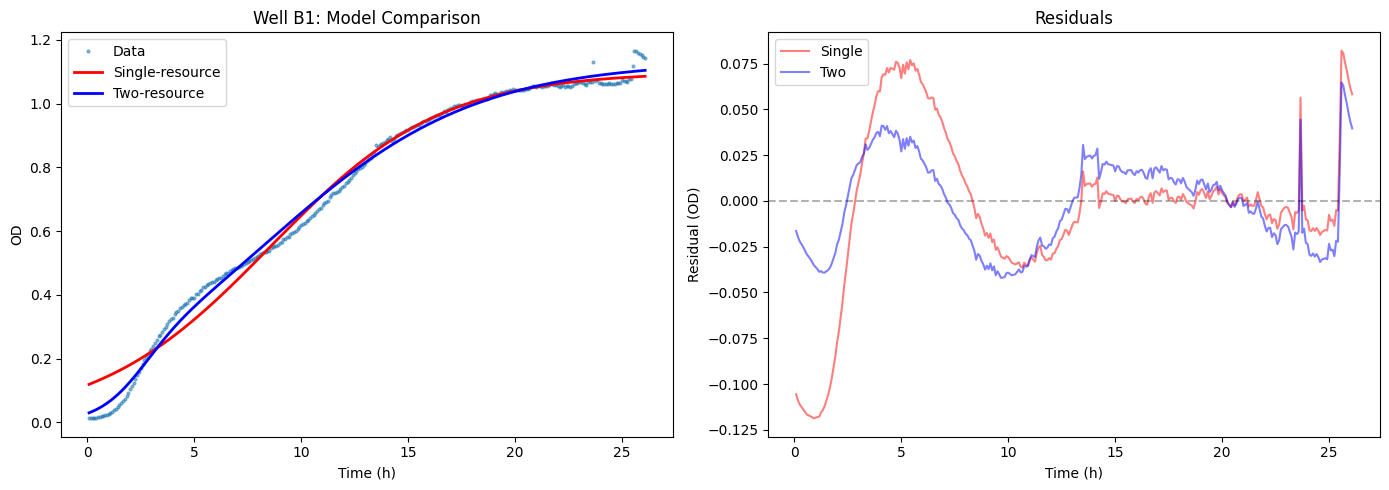

In [17]:
k_s = mu_s / K_s
S0_s = K_s - X0_s
y_single = simulate_logistic(t_exp_b1, Q(k_s, 'hour**-1 / OD'),
                            Q(S0_s, 'OD'), Q(X0_s, 'OD'))

k1_t, k2_t = mu1_t/K1_t, mu2_t/K2_t
S1_0_t, S2_0_t = K1_t - X0_t, K2_t - X0_t
y_two = simulate_two_resource(t_exp_b1, Q(k1_t, 'hour**-1 / OD'), Q(k2_t, 'hour**-1 / OD'),
                              Q(S1_0_t, 'OD'), Q(S2_0_t, 'OD'), Q(X0_t, 'OD'))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(t_exp_b1.m, od_exp_b1.m, 'o', markersize=2, alpha=0.5, label='Data')
ax1.plot(t_exp_b1.m, y_single.m, 'r-', linewidth=2, label='Single-resource')
ax1.plot(t_exp_b1.m, y_two.m, 'b-', linewidth=2, label='Two-resource')
ax1.set_xlabel('Time (h)')
ax1.set_ylabel('OD')
ax1.set_title('Well B1: Model Comparison')
ax1.legend()

residuals_single = (od_exp_b1 - y_single).m
residuals_two = (od_exp_b1 - y_two).m

ax2.plot(t_exp_b1.m, residuals_single, 'r-', alpha=0.5, label='Single')
ax2.plot(t_exp_b1.m, residuals_two, 'b-', alpha=0.5, label='Two')
ax2.axhline(0, color='k', linestyle='--', alpha=0.3)
ax2.set_xlabel('Time (h)')
ax2.set_ylabel('Residual (OD)')
ax2.set_title('Residuals')
ax2.legend()

plt.tight_layout()
plt.show()

When should you consider model extensions? When residuals show systematic patterns (not random scatter). When the objective function is much larger than expected from noise alone. When you have biological plausibility (known presence of multiple carbon sources). When model comparison criteria favor the complex model. But be careful: more parameters tend to fit better. Don't overfit. Use your biological knowledge to justify model complexity.

## Summary

Parameter estimation bridges data and mechanism. We've seen that inverse problems are hard because many parameter sets can produce similar curves. Identifiability depends on whether your data covers the full process. The optimization landscape has local minima, flat regions, and elongated valleys that make finding the global minimum challenging.

For methods, gradient descent is fast if you have a good starting point but fragile otherwise. Global optimization is robust but slow. The combined strategy (quick differential evolution followed by local refinement) gives you the best of both worlds.

In practice, reparameterize to observable quantities like $(\mu, K, X_0)$ for easier optimization. Always check residuals for systematic patterns. Consider model extensions when simple models fail systematically, but don't overfit.

The key lessons: Start with the simplest model that captures your process. Use the combined optimization strategy unless you have a good initial guess. Check identifiability by examining whether your data covers the full dynamic range. Examine residuals carefully. Validate biologically by asking whether fitted parameters make sense.

Parameter estimation is both art and science. The algorithms are tools, but you need biological insight to use them well. When a fit fails, ask: is it the optimization, the model, or the data?

---
**License**: © 2025 Matthias Függer and Thomas Nowak. Licensed under [CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/).